In [14]:
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta
import matplotlib.pyplot as plt
from scipy import stats,optimize
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_squared_error
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import math

In [368]:
#to - get apis for other weather data (pressure, humidity etc - look at documentation)
#figure out what's going wrong with time series order
#test WT-08 with offset
#expand on pollution data
#get weather station(s) by zip code - difficult
#get time as just hour

In [21]:
def get_breath_data(filepath,):
    file1 = open(filepath, 'r')
    if (file1.readline() == '\n'):
        operating_system = 'windows'
    else:
        operating_system = 'other'
    file1.close()
    if (operating_system == 'windows'):
        raw_spiro = pd.read_csv(filepath,header=8) #earlier rows contain patient information
        raw_spiro = raw_spiro.drop(['Unnamed: 4'], axis=1)
    else:
        raw_spiro = pd.read_csv(filepath)
    raw_spiro['Date'] = pd.to_datetime(raw_spiro['Date'])
    raw_spiro['unixDate']= raw_spiro['Date']
    raw_spiro['unixDate']= raw_spiro['unixDate'].astype(np.int64)// 10**9
    raw_spiro['unixDate'] = raw_spiro['unixDate']/86400

    #get time in datetime format
    if (operating_system == 'windows'):
        raw_spiro = raw_spiro[raw_spiro['Time'].str.find('0')!=0]
        raw_spiro['Time']=pd.to_datetime(raw_spiro['Time'],format= '%I:%M %p' )
    else:
        raw_spiro['Time']=pd.to_datetime(raw_spiro['Time'],format= '%H:%M' )#.dt.time
        raw_spiro=raw_spiro.rename(columns={"PEF": "PEF(l/min)","FEV1":"FEV1(l)"})
    raw_spiro['unixTime'] = raw_spiro['Time'].apply(lambda x: timedelta(hours=x.hour, minutes=x.minute).total_seconds())
    raw_spiro['Hour']=raw_spiro['unixTime']/(60*60)
    return raw_spiro

In [22]:
raw_spiro=get_breath_data('./C.csv')
raw_spiro=pd.concat([get_breath_data('./B.csv'), raw_spiro])
raw_spiro = raw_spiro.reset_index()
raw_spiro = raw_spiro.drop(['index'],axis=1)
raw_spiro.to_csv('raw_spiro.csv',index=False)

In [34]:
#linear regression which plots and gives coefficient and R-squared
def lin_reg_plot(X,Y):
    regr = linear_model.LinearRegression()
    X = X.values.reshape(-1, 1)
    Y = Y.values.reshape(-1, 1)
    regr.fit(X, Y)
    Y_pred = regr.predict(X)    
    # Plot outputs
    plt.figure(figsize=(8, 8))
    plt.plot(X, Y_pred, color='red')
    plt.scatter(X, Y)
    plt.show()
    print('Coefficient: \n', round(regr.coef_[0][0],2))
    print('R-squared: %.2f'
          % r2_score(Y, Y_pred))

In [27]:
Y = raw_spiro['PEF(l/min)']
X = raw_spiro[['FEV1(l)','Hour']]

mod = sm.OLS(Y,X)
fit = mod.fit()
summary = fit.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             PEF(l/min)   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          1.311e+04
Date:                Thu, 02 Apr 2020   Prob (F-statistic):                   2.42e-215
Time:                        17:01:34   Log-Likelihood:                         -1020.2
No. Observations:                 205   AIC:                                      2044.
Df Residuals:                     203   BIC:                                      2051.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FEV1(l)      151.5482      1.876     80.791      0.000     147.850     155.247
Hour           0.5965      0.334      1.786      0.076      -0.062       1.255
==============================================================================
Omnibus:                       63.820   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.354
Skew:                           1.092   Prob(JB):                     1.22e-69
Kurtosis:                       8.690   Cond. No.                         11.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

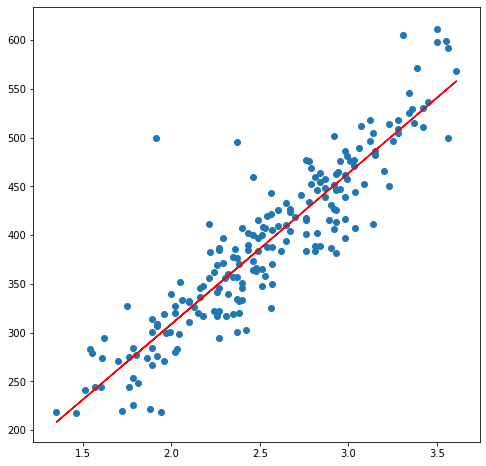

Coefficient: 
 154.66
R-squared: 0.83


In [35]:
lin_reg_plot(raw_spiro['FEV1(l)'],raw_spiro['PEF(l/min)'])
#there's a clear connection between FEV and PEV

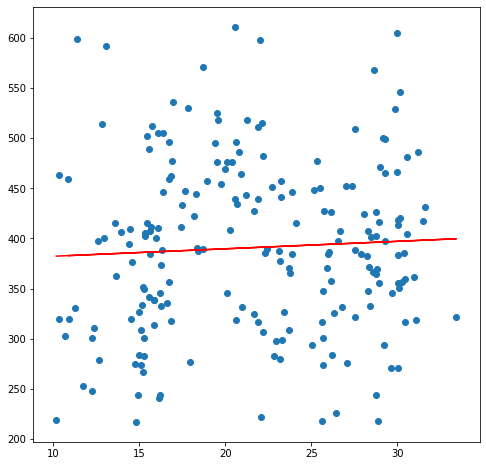

Coefficient: 
 0.75
R-squared: 0.00


In [60]:
#lin_reg_plot(raw_spiro['Hour'],raw_spiro['PEF(l/min)'])
#weak relationship between PEF and time of day
sleepTest = raw_spiro.copy() 
#wakeTest = sleepTest.where(sleepTest['Hour']>10).dropna()
sleepTest.loc[sleepTest['Hour']  10,'Hour'] = sleepTest['Hour']+24
lin_reg_plot(sleepTest['Hour'],sleepTest['PEF(l/min)'])

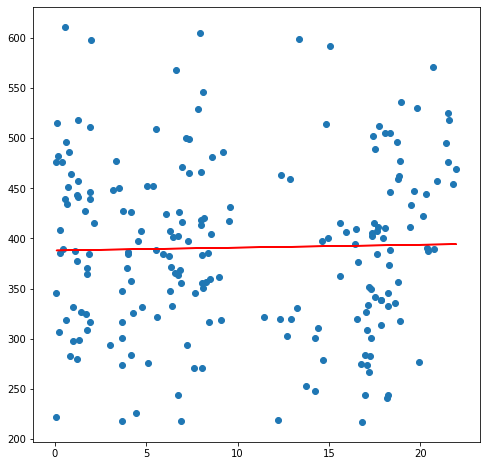

Coefficient: 
 0.29
R-squared: 0.00


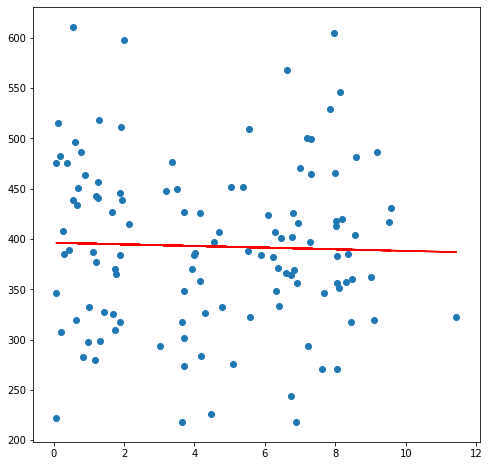

Coefficient: 
 -0.81
R-squared: 0.00


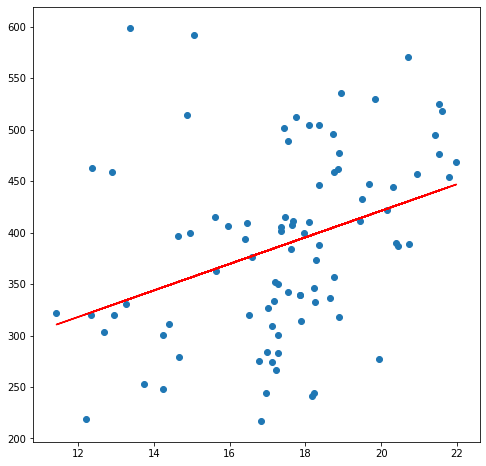

Coefficient: 
 12.91
R-squared: 0.12


In [56]:
#test hypothesis that breathing gets worse during sleep - sleep is from 22 - 6 - adding buffer
sleepTest = raw_spiro.copy() 
sleepTest = sleepTest.drop(['unixDate'],axis=1)
sleepTest.reset_index(drop=True)
#same data - just starting around sleeptime and setting that to zero
sleepTest.loc[sleepTest['Hour'] <= 22,'Hour'] = sleepTest['Hour']+2
sleepTest.loc[sleepTest['Hour'] >= 22,'Hour'] = sleepTest['Hour']-22
wakeTest = sleepTest.copy()
baseTest = sleepTest.copy()
lin_reg_plot(baseTest['Hour'],baseTest['PEF(l/min)'])
sleepTest = sleepTest.where(sleepTest['Hour']<=12).dropna()
lin_reg_plot(sleepTest['Hour'],sleepTest['PEF(l/min)'])
wakeTest = wakeTest.where(wakeTest['Hour']>10).dropna()
lin_reg_plot(wakeTest['Hour'],wakeTest['PEF(l/min)'])
#no clear worsening of breath during sleep - but improvement during wake - let's examine a time series analysis

In [260]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=3,center=False).mean()
    rolstd = timeseries.rolling(window=3,center=False).std()
    #Plot rolling statistics:
    plt.figure(figsize=(8, 8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(dfoutput)

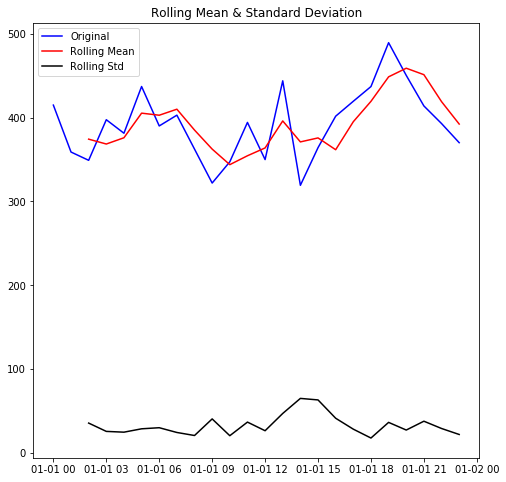

Results of Dickey-Fuller Test:
Test Statistic                 -3.269199
p-value                         0.016313
#Lags Used                      0.000000
Number of Observations Used    23.000000
dtype: float64


In [304]:
X = raw_spiro.copy()
X = X.set_index('Time')
X = X['PEF(l/min)']
X = X.resample('H').mean()
X = X.interpolate()
test_stationarity(X)

In [305]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [315]:
#not sure why this fails to give best p,d,q
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                mse = evaluate_arima_model(dataset, order)
                print (order, mse)
                if mse < best_score:
                    best_score, best_cfg = mse, order
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 1)
solution = evaluate_models(X, p_values, d_values, q_values)

(0, 0, 0) 2391.323143199315
(0, 1, 0) 1315.5864895752654
(0, 2, 0) 4685.481597901743
(1, 0, 0) 2263.294515220249
(1, 1, 0) 2164.0794298596234
(1, 2, 0) 3545.5458947883894
(2, 0, 0) 2359.7143111779333
(2, 1, 0) 2440.259281180114
(2, 2, 0) 3304.201384065507
Best ARIMA(0, 1, 0) MSE=1315.586


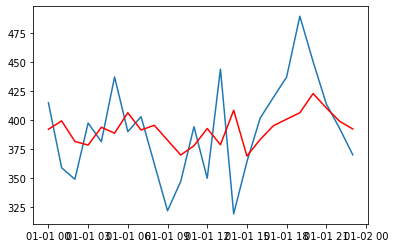

In [313]:
model = ARIMA((X),order=(1,0,0),freq='H')
results_AR= model.fit()
plt.plot(X)
plt.plot(results_AR.fittedvalues,color='red')

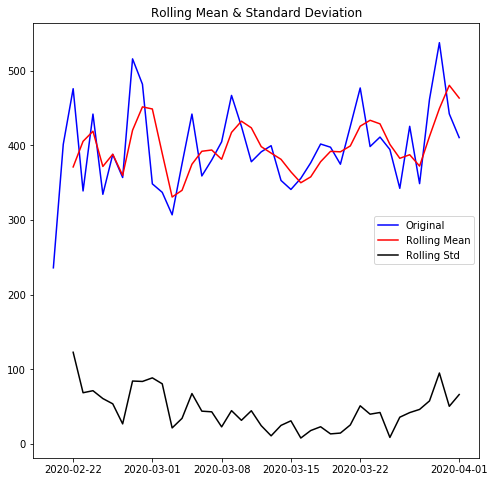

Results of Dickey-Fuller Test:
Test Statistic                 -2.882921
p-value                         0.047370
#Lags Used                      5.000000
Number of Observations Used    36.000000
dtype: float64


In [316]:
#I want to figure out how to analyze time series by both day and between days
X2 = raw_spiro.copy()
X2 = X2.groupby('Date').mean()
#X2.set_index('unixDate', inplace=True)
X2.index
X2.set_index(pd.date_range(start=X2.index.min(), end=X2.index.max()), inplace=True)
#X2.index
X2 = X2['PEF(l/min)']

test_stationarity(X2)

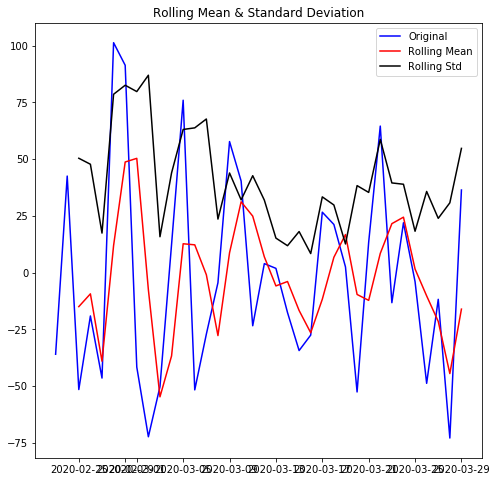

Results of Dickey-Fuller Test:
Test Statistic                 -5.17200
p-value                         0.00001
#Lags Used                     10.00000
Number of Observations Used    25.00000
dtype: float64


In [317]:
#more seasonal analysis once I have more data
decomposition = seasonal_decompose(X2)
trend = decomposition.trend
seasonal = decomposition.seasonal

residual = decomposition.resid
test_stationarity(residual.dropna())

(0, 0, 0) 2992.3635793964327
(0, 1, 0) 3918.068111499007
(0, 2, 0) 10179.423302629724
(1, 0, 0) 2900.247526860488
(1, 1, 0) 3672.3813676819263
(1, 2, 0) 6997.7768504966525
(2, 0, 0) 3082.8456142169966
(2, 1, 0) 3202.8579219834023
(2, 2, 0) 5310.352816918106
Best ARIMA(1, 0, 0) MSE=2900.248


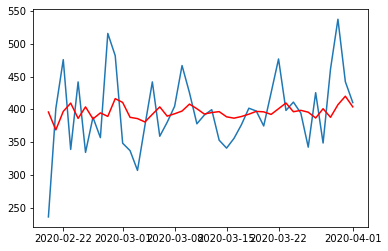

In [318]:
solution = evaluate_models(X2, p_values, d_values, q_values)
model = ARIMA((X2),order=solution,freq='D')
results_AR= model.fit()
plt.plot(X2)
plt.plot(results_AR.fittedvalues,color='red')